----
# Logistic Regression with Augmented Data
----
### Summary:

Evaluating the performance of the baseline Logistic Regression model when trained on augmented data. By augmenting MNIST sign language dataset, more noise is added to the images which simulate real-world scenarios. Training the model on augmented data allows the model to generalise better and therefore become more robust.

### Notebook Overview:

- **Data Augmentation**:
    - Load augmented data.
- **Data Visualisation**:
    - Visualise and assess the augmentation of data.
- **Build Logistic Regression Model**:
    - Train Logistic Regression model(with same params as 01 notebook) on the augmented data.
    - Compare the performance of the model with and without augmentation.

- **Model Evaluation**:
    - Evaluate the accuracy and performance of the Logistic Regression model.
    - Assess model coefficients to see what model has learnt when data includes augmentation.

### Data Augmentation Reminder:

- rescale=1./255             
    > Normalisation of the input data is best when working with neural networks
- rotation_range=20          
    > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      
    > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     
    > To ensure model is able to deal with off-centered images
- shear_range=0.2            
    > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             
    > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=True       
    > To mimic opposite hand, if original image is left hand we can flip the image to show right hand


## Set Up
---

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

import joblib

## Data Loading
----

In [54]:
X_train_aug = joblib.load( '../../data/my_data/X_train_aug.pkl')
y_train_aug = joblib.load( '../../data/my_data/y_train_aug.pkl')

In [55]:
X_val_aug = joblib.load( '../../data/my_data/X_val_aug.pkl')
y_val_aug = joblib.load( '../../data/my_data/y_val_aug.pkl')

### Getting images out of batches from keras

In [56]:
train_images = []

# Iterate over each array in X_aug
for batch in X_train_aug:
    # Iterate over each image in the batch
    for image in batch:
        image *= 255
        # Append the image to the list of all images
        train_images.append(image)

# Convert the list of images to a NumPy array
train_images_array = np.array(train_images)

In [57]:
train_class = []

# Iterate over each array in X_aug
for batch in y_train_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        train_class.append(c)

# Convert the list of images to a NumPy array
train_class_array = np.array(train_class)

In [58]:
train_images_array.shape

(27701, 28, 28, 1)

In [59]:
# Convert the list of images to a NumPy array
train_class_array.shape

(27701,)

In [60]:
# to check descaling works
train_images_array.max()

255.0

### Split X and y

In [61]:
X_train = train_images_array.reshape(-1,28,28)
y_train = train_class_array

In [62]:
X_train.shape # Sanity Check

(27701, 28, 28)

In [63]:
y_train.shape

(27701,)

In [64]:
# Defining variables to be used throughout the notebook
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y_train, return_counts=True)

## Utility Functions
----

In [65]:
# Addiing utility functions here as we require alphabet var to be defined
def assess_coef(coef, letter='a'):
    '''
    Overview:
    Plots the mean image of a given letter and the odds ratio image based on model coefficients.

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            -  mean image of given letter
            - 'odds ratio' pixel image for each given letter

    '''
    # Data set contains no data for letters j and z, to raise error message if input letter is j/z
    if letter.lower() in ('j', 'z'):
        raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:

        my_image = X_train.reshape(-1,28,28)
        my_class = y_train

        fig, axes = plt.subplots(1,2, figsize=(20, 10))

        # get index of letter as class is int data type
        idx1 = alphabet.index(letter.lower())

        plt.subplot(1,2,1)
        plt.imshow(np.mean(my_image[my_class==idx1], axis = 0) ,cmap='gray')
        plt.title(f'Mean of {letter.upper()}',fontsize='50')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(1,2,2)
        # Using cmap show the odds ratio -> cases where odds ratio is > 1 means certain pixel increases the odss of the image being classified as the target letter
        #                                -> cases where odds ratio is < 1 means certain pixel decreses the odds of the image being classified as the target letter
        plt.imshow(np.exp(coef[idx1]).reshape(28,28),cmap='BuPu')
        # added positioning to make colour bar same height as image
        plt.colorbar(label='Odds Ratio',fraction=0.046, pad=0.04)
        plt.title(f'Odds Ratio for {letter.upper()}',fontsize='50')

        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
        plt.show()

## Visualisation of Augmented Images
----

### Printing a single image for each character:

In [66]:
my_image = X_train
my_class = y_train

In [67]:
fig, axes = plt.subplots(6,4, figsize=(80, 120))

for target, ax in zip(unique_values, axes.ravel()):
    ax.imshow(my_image[my_class==target][0], cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


**Plot Description:**

For some images the augmentation is severe especially in cases where the images are significantly cropped. Due to the limited frame size 28 by 28 this provides limitations when it comes to augmentation. 

In terms of logistic regression, it is now a lot harder for the model to separate out classes as augmentation as there is a lot more variability now. 

### Printing mean image for each character:


In [68]:
fig, axes = plt.subplots(6, 4, figsize=(80, 120))
for target, ax in zip(unique_values, axes.ravel()):

    ax.imshow(np.mean(my_image[my_class==target], axis = 0), cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

**Plot Description:**

By plotting the mean of all images per class with augmentation, it becomes clear jsut how drastic the augmentation has been on the dataset. In contrast to the non-augmented data (refer to notebook 01-log-reg-basic), the distinctive features previouslty observed are now a lot less prominent. Most signs now show more commonality especially in the image center pixels. This will make it challenging for the model to distinguish between different sign language signs. This is reflected in the logistic model's results below, where performance has significantly declined. The basic logistic regression model struggles when images are off-centered and contain more noise, highlighting its limitations despite showing high accuracy in the initial modelling.

## Building the Logistic Regression Model

---

In [70]:
flattened_X_train = X_train.reshape(X_train.shape[0],28 * 28)

In [71]:
# no need to scale/normalise X as scaling done during augmenatation  
X_train = flattened_X_train

In [72]:
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)
my_model.fit(X_train, y_train)

/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

**Comment:** 

The model didn't even manage to converge using the same params as in notebook 01.

For comparison purposes I have kept all logistic regression notebook parameters the same for a fair comparison.

In [73]:
val_images = []

# Iterate over each array in X_aug
for batch in X_val_aug:
    # Iterate over each image in the batch
    for image in batch:
        image *= 255
        # Append the image to the list of all images
        val_images.append(image)

# Convert the list of images to a NumPy array
val_images_array = np.array(val_images)

In [74]:
val_class = []

# Iterate over each array in X_aug
for batch in y_val_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        val_class.append(c)

# Convert the list of images to a NumPy array
val_class_array = np.array(val_class)

In [75]:
X_val= val_images_array.reshape(-1,28,28)
y_val = val_class_array

In [76]:
flattened_X_val = X_val.reshape(X_val.shape[0],28 * 28)
X_val = flattened_X_val

In [93]:
print(f'train score: {my_model.score(X_train, y_train)}')
print(f'val_score:{my_model.score(X_val,y_val)}')

train score: 0.3172448648063247
val_score:0.258189312314701


In [78]:
joblib.dump(my_model, '../../model/my_models/log_reg_augmented_model.pkl')

['../../model/my_models/log_reg_augmented_model.pkl']

## Model Evaluation
----

In [79]:
my_final_model = joblib.load('../../model/my_models/log_reg_augmented_model.pkl')


##### Confusion Matrix:
Plotting a confusion matrix shows us the number of correctly and incorrecly classified images of the model.

In [80]:
pred_y = my_final_model.predict(X_val)

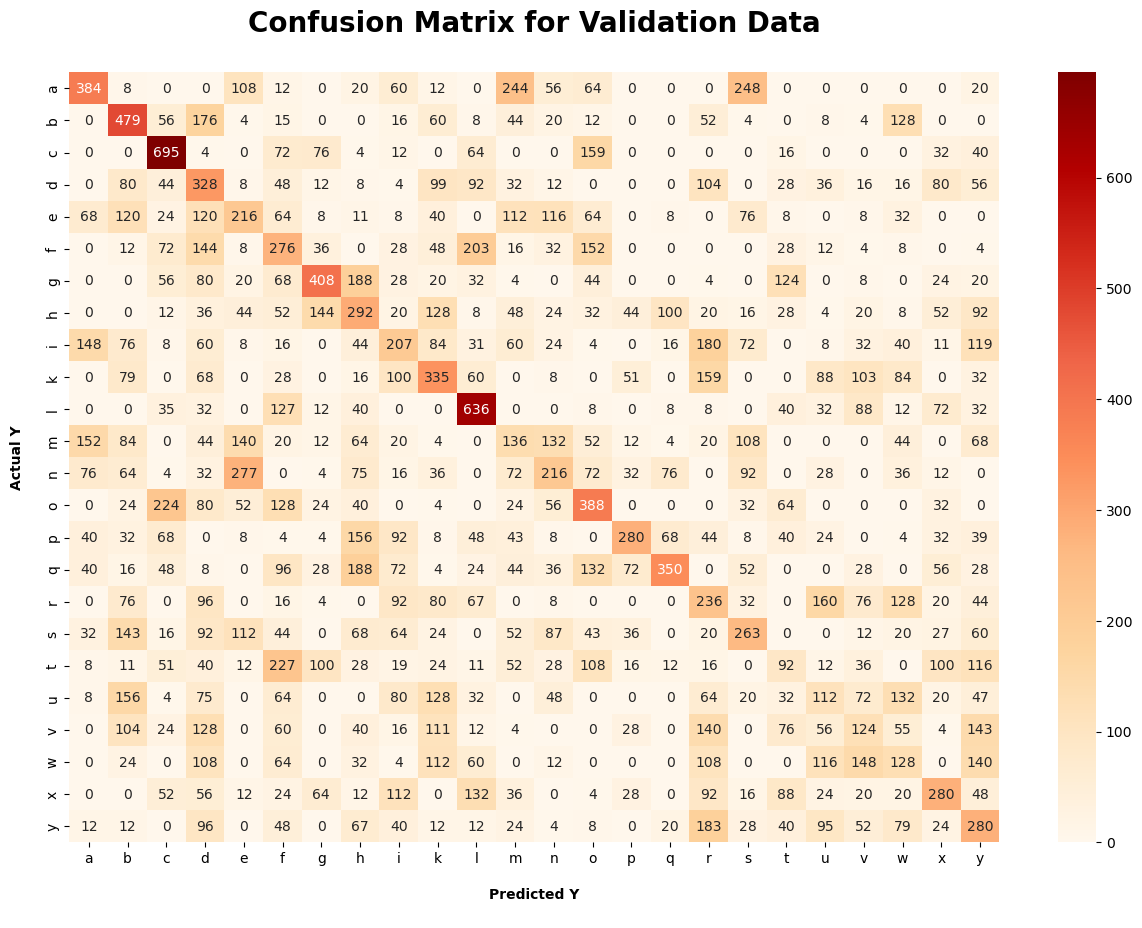

In [82]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Plot Description:**

The number of misclassifications has greatly increasesd compared to the previous evalutiuon of logistic regression model with the original data. The logistic model's ability to perform classification is no longer as effective.

Increased noise in the dataset leads to confusion, the model can no longer separate classes as clearly with a linear line as augmentation has likely removed some key features.

In [83]:
# Coefficient for each pixel
letter_coef = my_final_model.coef_

fig, axes = plt.subplots(6,4, figsize=(80, 120))

for i,coef in enumerate(letter_coef):
    plt.subplot(6,4,i+1)
    # To take the exponential each coefficient to output odds ratio
    plt.imshow(np.exp(coef).reshape(28,28) ,cmap='BuPu')
    plt.title(alphabet[i].upper(),fontsize='50') #-> using alphabet_jz as the i is 0 to 24
    plt.xticks([])
    plt.yticks([])
plt.show()

**Plot Description:**

The plot of the coefficients looks like 'snow' meaning the logistic model odds ratios no longer show a clear relationship between the pixels and classes. The scattered nature of the plots re-confirm what we have seen already - the augmentation has challenged the logisitic models ability to perform classification. This suggests that using this model in the real world will have limitations as it does not respond well to noise introduction.

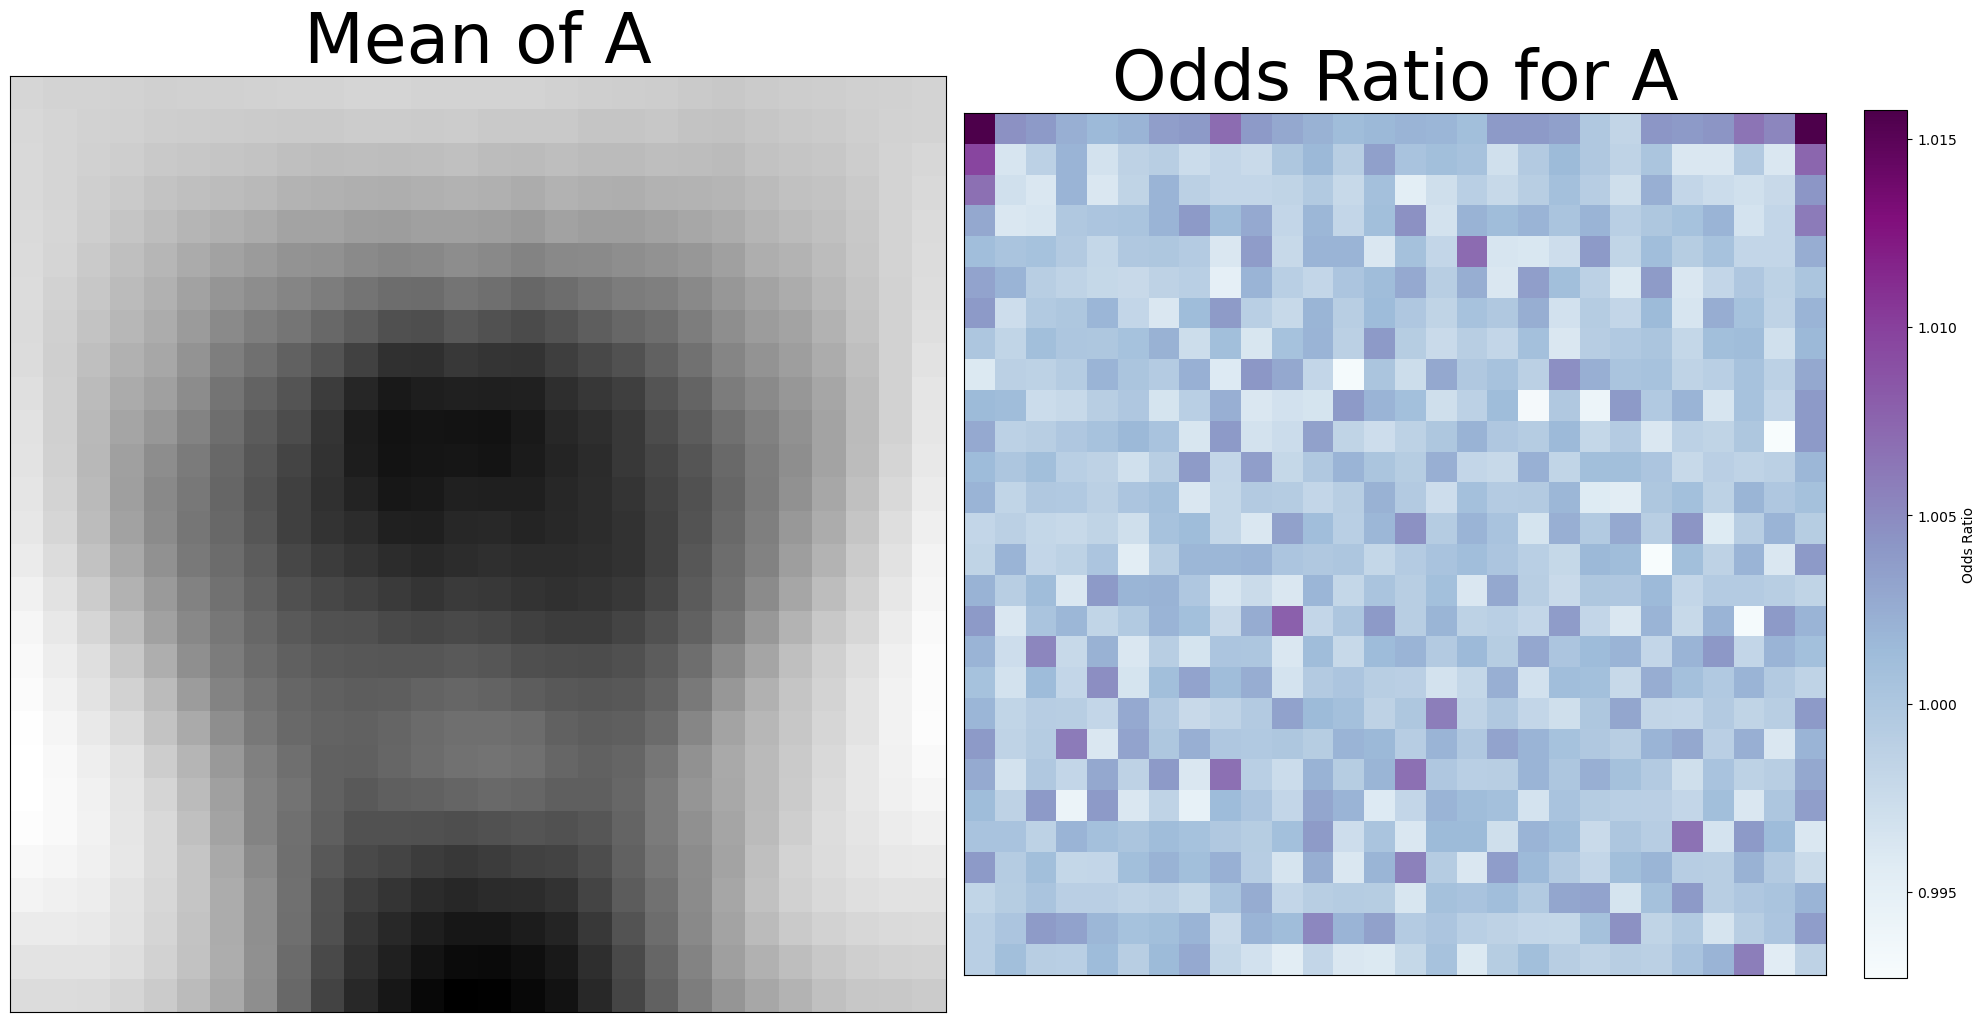

In [84]:
# Getting coefficients again to pass into my new function
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='A')

**Comment:**

For the mean of A there is basically no features the model learns to identify for A.

This could be as majority of the means of the classes all begin gather in the centre of the image, this means the characteristics shown in the previous notebook used to distinguish A are no longer distinct. I assume we will see the same result for other closed fist signs. 
See below:

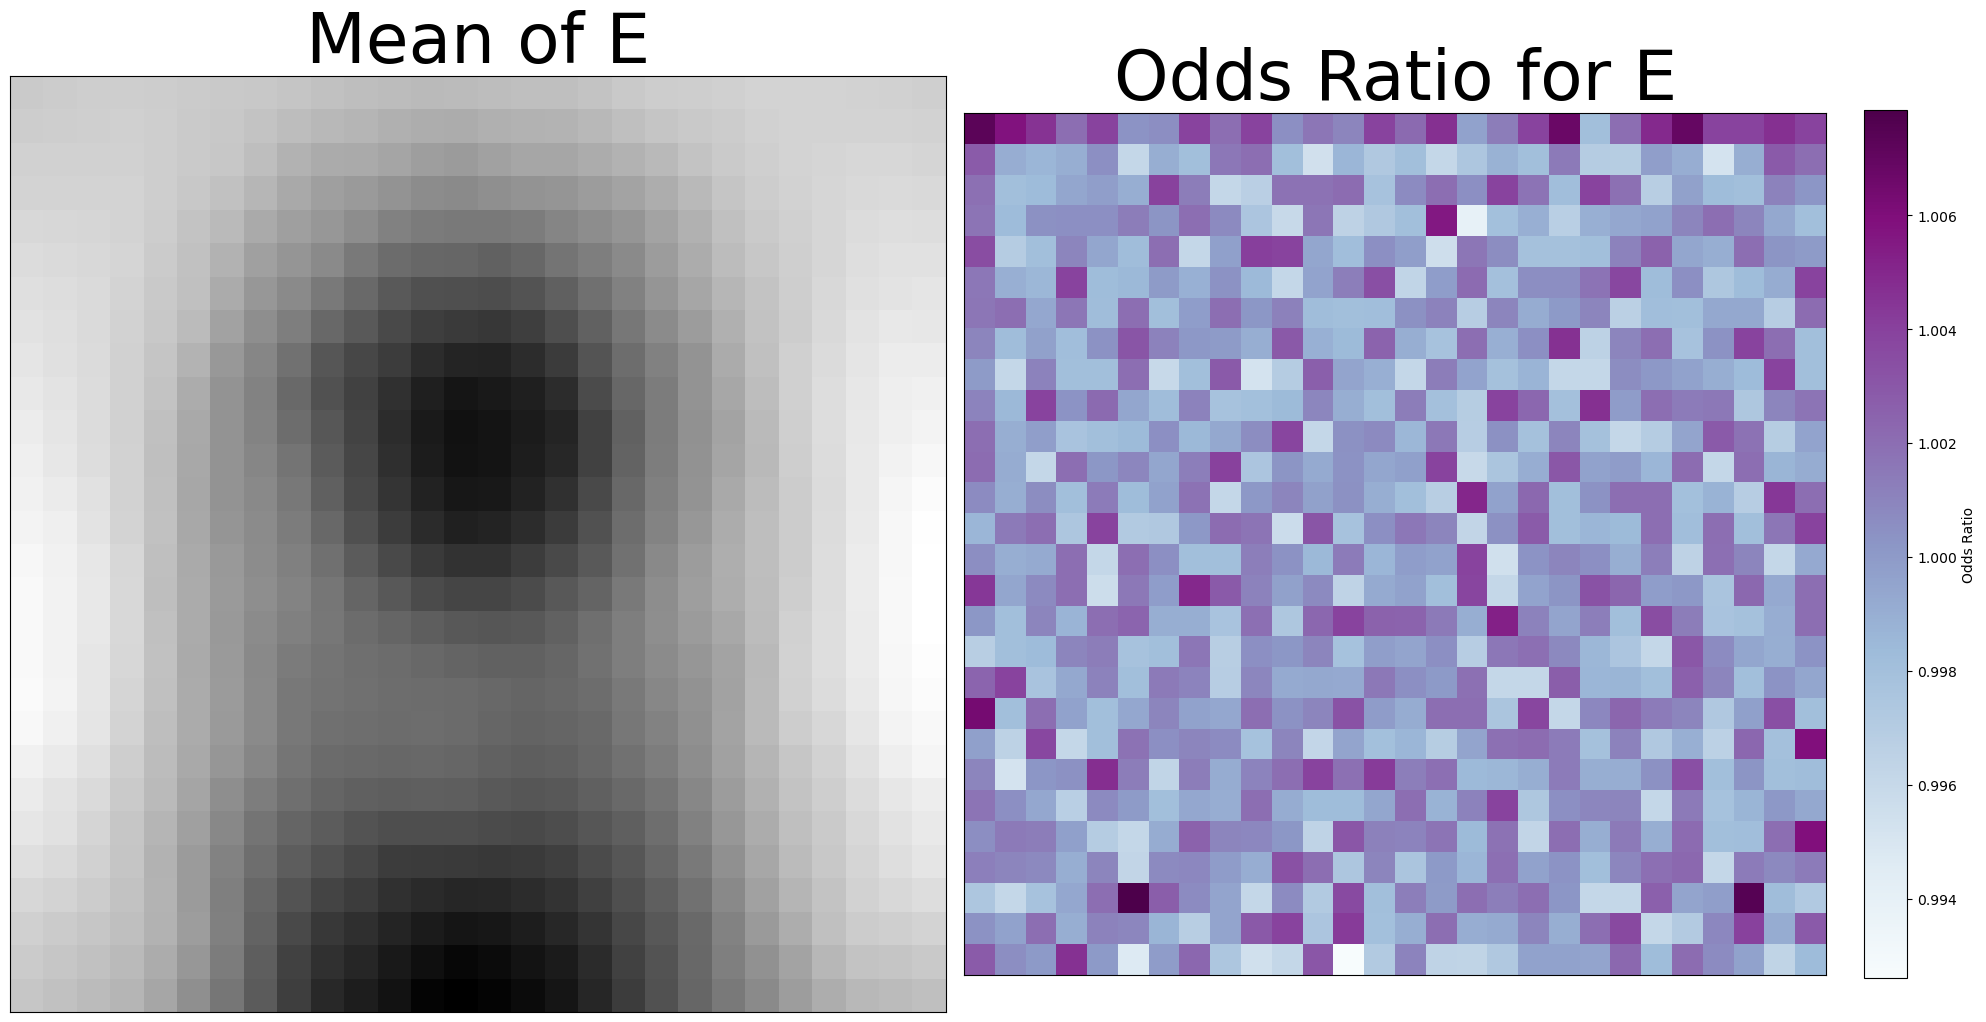

In [85]:
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='e')

### Testing an Unseen Input Image

In [86]:
my_final_model = joblib.load('../../model/my_models/log_reg_augmented_model.pkl')

In [87]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

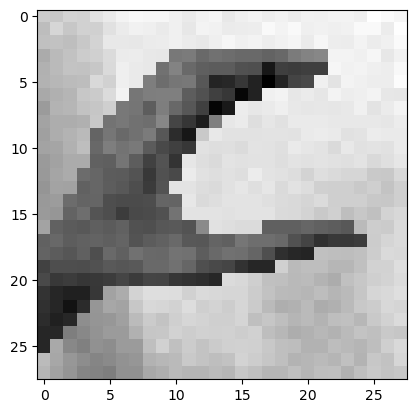

In [88]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [89]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image).astype(float)

In [90]:
test_img = image_array.reshape(1,28*28)

In [91]:
pred = my_final_model.predict(test_img)

In [92]:
print(f'Prediction using Logistic Regression with Data Augmentation: \n{alphabet[pred[0]].upper()}')

Prediction using Logistic Regression with Data Augmentation: 
P


## Conclusion
---

| Logistic Regression Model | Without Augmentation | With Augmentation  |
|---------------------------|----------------------|--------------------|
| Train Score               | 99.99                | 31.72              |
| Validation Score          | 99.98                | 25.82              |

There is a great difference in performance between logsitic regression with augmented data and without augmented data. This suggests the augmentation I performed is too harsh for the logistic regression model. However since I will be exploring other non-linear models I decided to keep the augmentation parameters as they are.

If we focus purely on the augmented data results, there is some overfitting. Perhpahs the model failed to be able to recognise influential/discriminative features for each class. We can see this when we plot the mean of images of augmented data per class. 

Next, we will assess how well feature extraction will handle augmented data. Since feature extraction is highlighting more complex features in images I expect the performance to be higher.